In [33]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

# Employee Turnover Prediction

## 1. Problem formulation

**1.1. Problem Formulation**

The objective of this project is to develop a Bayesian predictive model to forecast which employees are likely to leave their jobs in the near future. Employee turnover poses a significant challenge for organizations, impacting operational efficiency and increasing costs.

We assume that employees' decisions to leave are independent of each other, meaning that an employee's decision to leave depends solely on their own characteristics and is not directly related to the decisions of other employees. We are disregarding external factors that may change over time, such as changes in company policy, labor market fluctuations, etc., which could influence employees' decisions to leave.

**The aim of the project is to predict which employee is likely to leave the organization based on their demographic, professional, and psychological attributes.**

We believe that our model can be useful. The anticipated use cases of the proposed model are described below.

* **Human Resource Management**

    HR specialists can use the model to identify employees at risk of leaving, enabling the implementation of targeted retention strategies and minimizing the loss of key talents.

* **Workforce Planning**

    Managers can utilize the model's predictions for more effective human resource planning, allowing them to prepare for potential departures and prevent staffing shortages.

* **Decision Support**

    The company's management can use the model's results to understand the main factors influencing employee turnover, supporting decisions regarding employment policies and retention strategies.

* **HR Consulting**

    HR consultants can use the model to advise companies on improving employment policies, reducing turnover rates, and increasing employee satisfaction through more targeted actions.

**1.2. Survival Analysis**

The employee turnover problem can be considered as a part of **Survival Analysis**, also known as time-to-event analysis. It focuses on analyzing the time until an event of interest occurs. This type of analysis is particularly useful in fields like medicine, engineering, and social sciences where the timing of events is crucial.

**1.2.1. Key Concepts in Survival Analysis**

- **Event of Interest:** The specific occurrence being studied, such as death, failure of a machine, or relapse of a disease.

- **Survival Time:** The time from the beginning of the observation period to the event of interest. If the event has not occurred by the end of the study, the survival time is censored.

- **Censoring:** This occurs when the exact survival time is not known. Common types of censoring include right-censoring (event hasn't occurred by the end of the study) and left-censoring (event occurred before the study began).

- **Survival Function $ (S(t)) $:** A function that provides the probability that the time to the event is greater than a specified time t. It describes how the probability of survival decreases over time.

- **Hazard Function $ (h(t)) $:** The instantaneous rate at which events occur, given no prior occurrence. It describes the risk of the event happening at time $ t $.

**1.2.2. Types of Survival Models**

* **Non-Parametric Models:**
   - **Kaplan-Meier Estimator:** A method to estimate the survival function from lifetime data. It provides a step function representing the probability of surviving past certain time points.
   - **Log-Rank Test:** A hypothesis test to compare the survival distributions of two or more groups.

* **Semi-Parametric Models:**
   - **Cox Proportional Hazards Model:** A widely used model that assesses the effect of covariates on the hazard rate. It assumes that the hazard ratios are constant over time (proportional hazards).

* **Parametric Models:**
   - **Exponential Model:** Assumes the hazard function is constant over time, leading to an exponential distribution of survival times.
   - **Weibull Model:** Generalizes the exponential model by allowing the hazard function to vary over time, providing more flexibility.
   - **Log-Normal and Log-Logistic Models:** Useful for modeling survival times with a particular skewed distribution.

In our project, as we are focused on parametric and semi-parametric models, we decided to do such analysis using [Weibull distribution](https://en.wikipedia.org/wiki/Weibull_distribution).

**1.2.3. Weibull distribution**

The Weibull distribution is a versatile and widely used probability distribution in survival analysis and reliability engineering. It can model various types of survival data, including both increasing and decreasing hazard rates over time, making it suitable for different scenarios.


**Why Weibull Distribution for Employee Turnover**

The Weibull distribution is a good choice for modeling employee turnover for several reasons:
- **Flexibility in Hazard Rates:** Employee turnover might not follow a constant hazard rate. For example, new employees might be more likely to leave within the first few months (decreasing hazard), or employees might be more likely to leave as they gain experience and seek better opportunities (increasing hazard). The Weibull distribution can model both scenarios.
- **Generalization of Exponential Distribution:** If employee turnover has a constant hazard rate, the Weibull distribution simplifies to the exponential distribution (k = 1), providing a more general modeling framework.
- **Ease of Interpretation:** The shape and scale parameters have intuitive interpretations related to the risk of turnover over time and the characteristic time to turnover, respectively.


**Parameters of the Weibull Distribution**

The Weibull distribution is characterized by two parameters:
* **Shape Parameter (k or $ \alpha $):** This parameter determines the shape of the hazard function.
   - **$ k < 1 $:** The hazard function is decreasing over time (useful for modeling early failures).
   - **$ k = 1 $:** The hazard function is constant over time (equivalent to an exponential distribution).
   - **$ k > 1 $:** The hazard function is increasing over time (useful for aging processes where the risk of failure increases with time).

* **Scale Parameter (λ or $ \beta $):** This parameter scales the distribution along the time axis. It is a measure of the characteristic life of the population.

The probability density function (pdf) of the Weibull distribution is:
   * $ f(t | k, \lambda) = \frac{k}{\lambda} \left(\frac{t}{\lambda}\right)^{k-1} e^{-\left(\frac{t}{\lambda}\right)^k} $

And the hazard function is:
   * $ h(t | k, \lambda) = \frac{k}{\lambda} \left(\frac{t}{\lambda}\right)^{k-1} $


**1.3. Data source**

Employee turnover results from various factors, including demographic information, job roles, industry type, and psychological characteristics. 

This Employee Turnover dataset is a real dataset shared from Edward Babushkin's blog used to predict an employee's risk of quitting. The dataset consists of 1129 records with the following features:

* **stag:** Employee's tenure at the company.
* **event:** Target variable indicating turnover (1 for leaving, 0 for staying).
* **gender**: Employee's gender (m for male, f for female).
* **age:** Employee's age.
* **industry:** Industry in which the employee works.
* **profession:** Employee's occupation.
* **traffic:** Commuting source, indicating how the employee gets to work.
* **coach:** Indicates whether the employee has a coach (yes or no).
* **head_gender:** Gender of the supervisor.
* **greywage:** Type of wage (white for regular wage).
* **way:** Mode of transportation to work (bus, car, etc.).
* **extraversion:** Employee's extraversion score.
* **independ:** Employee's independence score.
* **selfcontrol:** Employee's self-control score.
* **anxiety:** Employee's anxiety score.
* **novator:** Employee's innovativeness score.


Data has been downloaded from kaggle.

https://www.kaggle.com/datasets/davinwijaya/employee-turnover

## 2. Data preprocessing

**2.1. Data overview**

Firstly, let's print out our data to see sample of records that are there.

In [2]:
df = pd.read_csv("turnover.csv", encoding = "ISO-8859-1")
df.head()

,stag,event,gender,age,industry,profession,traffic,coach,head_gender,greywage,way,extraversion,independ,selfcontrol,anxiety,novator
0,7.030801,1,m,35.0,Banks,HR,rabrecNErab,no,f,white,bus,6.2,4.1,5.7,7.1,8.3
1,22.965092,1,m,33.0,Banks,HR,empjs,no,m,white,bus,6.2,4.1,5.7,7.1,8.3
2,15.934292,1,f,35.0,PowerGeneration,HR,rabrecNErab,no,m,white,bus,6.2,6.2,2.6,4.8,8.3
3,15.934292,1,f,35.0,PowerGeneration,HR,rabrecNErab,no,m,white,bus,5.4,7.6,4.9,2.5,6.7
4,8.410678,1,m,32.0,Retail,Commercial,youjs,yes,f,white,bus,3.0,4.1,8.0,7.1,3.7


In [3]:
df["event"].sum()

571

The data looks good at the first look, but we can get some more details about it to have overall look.

In [4]:
df.describe()

,stag,event,age,extraversion,independ,selfcontrol,anxiety,novator
count,1129.000000,1129.000000,1129.000000,1129.000000,1129.000000,1129.000000,1129.000000,1129.000000
mean,36.627526,0.505757,31.066965,5.592383,5.478034,5.597254,5.665633,5.879628
std,34.096597,0.500188,6.996147,1.851637,1.703312,1.980101,1.709176,1.904016
min,0.394251,0.000000,18.000000,1.000000,1.000000,1.000000,1.700000,1.000000
25%,11.728953,0.000000,26.000000,4.600000,4.100000,4.100000,4.800000,4.400000
50%,24.344969,1.000000,30.000000,5.400000,5.500000,5.700000,5.600000,6.000000
75%,51.318275,1.000000,36.000000,7.000000,6.900000,7.200000,7.100000,7.500000
max,179.449692,1.000000,58.000000,10.000000,10.000000,10.000000,10.000000,10.000000


As we can see, the numerical data that desribes employee character like extraversion, anxiety, etc. are normalized in the values range 0 - 10 which is good. Also the 'age' column has values between 18 and 58 which sounds reasonable and makes us sure we have no outliers in the dataset. Column named 'event' has also proper values as it contains probability values for each employee. Now, when we are sure we have no outliers nor any other strange values here, let's see if there are some NaN's.  

In [5]:
df.isnull().sum()

stag            0
event           0
gender          0
age             0
industry        0
profession      0
traffic         0
coach           0
head_gender     0
greywage        0
way             0
extraversion    0
independ        0
selfcontrol     0
anxiety         0
novator         0
dtype: int64

**2.2. Categorical data encoding**

Now when we are sure that our numerical data are fine, we can take a look at the categorical ones. To make it usefull in our project we should firstly encode its values to make its type numerical. For this we can use `LabelEncoder` from `scikit-learn` library.

In [6]:
encoding_map = {}
for col in df.columns:
    if df[col].dtype == 'object':
        labels = df[col].unique()
        
        encoder = LabelEncoder()
        encoder = encoder.fit(df[col])
        df[col] = encoder.transform(df[col].astype(str))
        
        map_column_values = {label: num for label, num in zip(labels, encoder.transform(labels))}
        encoding_map[col] = map_column_values

print(encoding_map)

{'gender': {'m': 1, 'f': 0}, 'industry': {'Banks': 2, 'PowerGeneration': 8, 'Retail': 10, 'manufacture': 14, 'Consult': 4, 'State': 11, 'etc': 13, 'Building': 3, 'IT': 5, ' HoReCa': 0, 'Telecom': 12, 'Pharma': 7, 'Mining': 6, 'transport': 15, 'Agriculture': 1, 'RealEstate': 9}, 'profession': {'HR': 6, 'Commercial': 2, 'Marketing': 9, 'etc': 13, 'Sales': 11, 'BusinessDevelopment': 1, 'Finanñe': 5, 'Teaching': 12, 'manage': 14, 'IT': 7, 'Law': 8, 'Consult': 3, 'Engineer': 4, 'PR': 10, 'Accounting': 0}, 'traffic': {'rabrecNErab': 4, 'empjs': 2, 'youjs': 7, 'referal': 6, 'advert': 1, 'KA': 0, 'recNErab': 5, 'friends': 3}, 'coach': {'no': 1, 'yes': 2, 'my head': 0}, 'head_gender': {'f': 0, 'm': 1}, 'greywage': {'white': 1, 'grey': 0}, 'way': {'bus': 0, 'car': 1, 'foot': 2}}


**2.3. Features normalization**

To have a reliable data representation for our modelling we should normalize our features.

In [7]:
features_columns = df.columns.to_list()
features_columns.remove("stag")
features_columns.remove("event")
features_matrix = df[features_columns].values

normalized_features_matrix = np.array([v / np.linalg.norm(v) for v in features_matrix[:]])
print(f"Feature matrix shape: {normalized_features_matrix.shape}")

Feature matrix shape: (1129, 14)


Now the dataset is fully ready to use in our modelling. We can also see the encoding map placed above to know which number represents which label in the original data. It will help us in better interpretation of the received results in the future. 

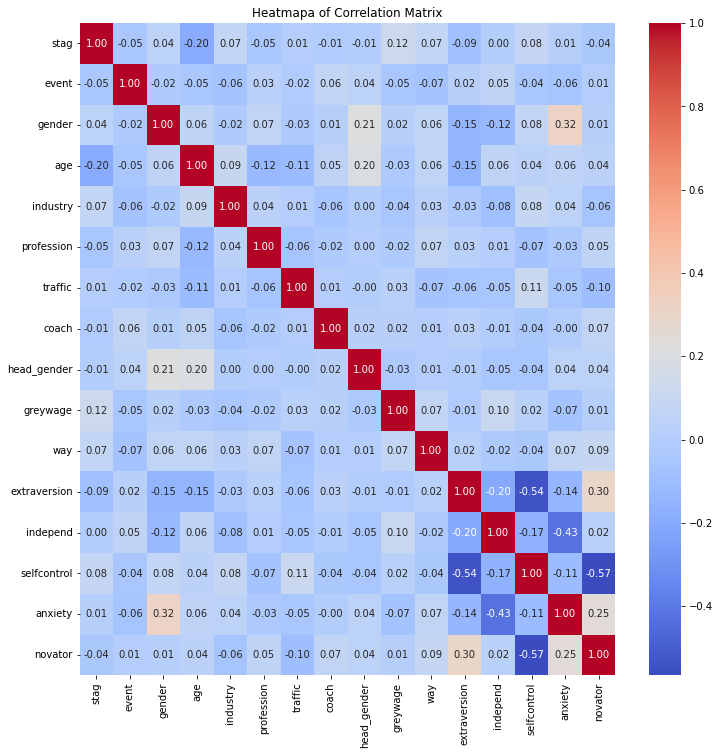

In [8]:
plt.figure(figsize=(12, 12))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmapa of Correlation Matrix')
plt.show()

## **3. Model**

Survival models come in two main flavors, parametric and semi-parametric. In a parametric model, the survival time of a subject is modeled explicitly using a parametric probability distribution. There is a great deal of flexibility in how the parametric probability distribution is constructed. Rather than explicitly modeling a parametric survival probability, semi-parametric survival models instead model the relative effect on survival of covariates.

In the Survival Analysis very common behaviour is to analyze influence of the covariates on the model's prediction. In an employee turnover problem, covariates could include a variety of factors that might impact the likelihood of an employee leaving the company, such as employee's age, gender, psycholigical factors and so on.

That is why we decided to create in our project two separate models, parametric and semi-parametric one.

**3.1. Weibull Model without Covariates**

This model only includes the shape parameter ($ k $) and scale parameter ($ \lambda $) of the Weibull distribution. It assumes that the survival times are only influenced by the Weibull distribution parameters and not by any covariates.

The survival function $ S(t) $, probability density function $ f(t | k, \lambda) $ and the hazard function $ h(t) $ for the Weibull distribution without covariates are:

$ f(t | k, \lambda) = \frac{k}{\lambda} \left(\frac{t}{\lambda}\right)^{k-1} e^{-\left(\frac{t}{\lambda}\right)^k} $

$ S(t | k, \lambda) = e^{-\left(\frac{t}{\lambda}\right)^{k}} $

$ h(t | k, \lambda) = \frac{k}{\lambda}\left(\frac{t}{\lambda}\right)^{k - 1} $

**Parameters**

- $ k $: Shape parameter
- $ \lambda $: Scale parameter

**Required Data**

- $ \text{target} $: Survival times (continuous)
- $ \text{censor} $: Censoring indicators (0 for observed, 1 for censored)


**3.2. Weibull Model with Covariates**

This model includes the shape parameter ($ k $), the scale parameter ($ \lambda $), and the regression coefficients ($ \theta $). It assumes that the survival times are influenced not only by the Weibull distribution parameters but also by covariates.

In this model, the scale parameter $ \lambda $ is modified by the covariates through a linear predictor $ \eta $:

$ \eta = X \theta $

where $ X $ is the matrix of covariates and $ \theta $ is the vector of regression coefficients. The survival, probability density and hazard functions become:

$ \lambda_i = e^{X_i \theta} $

$ S(t_i | k, \lambda_i) = e^{-\left(\frac{t_i}{\lambda_i}\right)^{k}} $

$ f(t_i | k, \lambda_i) = \frac{k}{\lambda_i} \left(\frac{t_i}{\lambda_i}\right)^{k-1} e^{-\left(\frac{t_i}{\lambda_i}\right)^k} $

$ h(t_i | k, \lambda_i) = \frac{k}{\lambda_i}\left(\frac{t_i}{\lambda_i}\right)^{k - 1} $

**Parameters**

- $ k $: Shape parameter
- $ \theta $: Regression coefficients (vector of length $ M $, where $ M $ is the number of covariates)

**Required Data**

- $ X $: Covariate matrix (dimensions $ N \times M $)
- $ \text{target} $: Survival times (continuous)
- $ \text{censor} $: Censoring indicators (0 for observed, 1 for censored)


## **4. Priors**

**4.1. Prior model**

Because of the fact that in the weibull distribution $ \lambda \in (0, +\infty) \land k \in (0, +\infty) $, we set lower limit for $ k $ and $ \lambda $ to $ 0 $. We also choose normal distribution to sample its values depending on the provided mean and standard deviation. 

```stan
data {
    int <lower=0> N; // number of observations

    real <lower=0> mu_k;          // mean for k
    real <lower=0> sigma_k;       // std for k
    real <lower=0> mu_lambda;     // mean for lambda
    real <lower=0> sigma_lambda;  // std for lambda
}

generated quantities {
    real <lower=0> lambda = normal_rng(mu_lambda, sigma_lambda);
    real <lower=0> k = normal_rng(mu_k, sigma_k);
    array [N] real y_sim; // simulated survival times
    for (n in 1:N) {
        y_sim[n] = weibull_rng(k, lambda);
    }
}
```

In [9]:
def do_sampling(
    model_path: str,
    data: dict,
    target: np.ndarray,
    censor: np.ndarray,
    do_plot: bool,
    **kwargs
) -> CmdStanModel:
    
    stan_model = CmdStanModel(stan_file=model_path)
    samples = stan_model.sample(
        data=data,
        **kwargs
    )
    
    times_sim = samples.stan_variable("y_sim")

    if do_plot:
        plt.hist(target[censor == 0], bins=30, color="green", edgecolor='black')
        plt.hist(times_sim[-1], bins=30, color="blue", edgecolor='black')
        plt.title(f'Histogram of times sampled using {model_path.split("/")[-1].split(".")[0]}')
        plt.xlabel('Time')
        plt.legend(["Times of observed events", "Times simulated"])
        plt.show()
    
    return stan_model, samples

In [10]:
target_array, censor_array = df["stag"].values, np.array(1 - df["event"].values)

print(f"Target array shape: {target_array.shape}")
print(f"Censor array shape: {censor_array.shape}")

Target array shape: (1129,)
Censor array shape: (1129,)


**4.2. Parameter values explanation**

While specifying parameters values we should take a look at our historical data. We can see at the times histogram shown below that the historical data suggest, that turnover decreases with employee tenure, so in our priors predictive model we should keep $ k > 1.0 $.

Based on the definition of Weibull distribution parameters, we set the $ k $ mean value $ \mu_k = 1.5 $ with standard deviation $ \sigma_k = 0.1 $.

In our first try we are using $ \mu_\lambda = 1 $ and $ \sigma_\lambda = 0.1 $ for the scale parameter $ \lambda $ as we do not want to scale our characteristic for now.

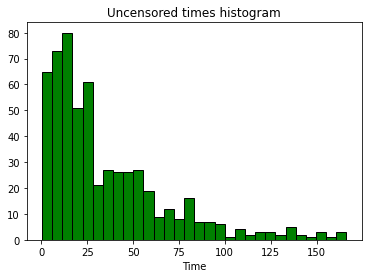

In [11]:
plt.hist(target_array[censor_array == 0], bins=30, color="green", edgecolor='black')
plt.title('Uncensored times histogram')
plt.xlabel('Time')
plt.show()

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


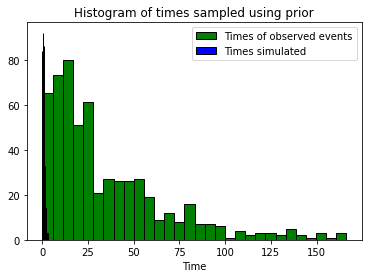

In [12]:
prior_model, prior_samples = do_sampling(
    model_path="stan/prior.stan",
    data={
        "N": normalized_features_matrix.shape[0],
        
        "mu_k": 1.5,
        "sigma_k": 0.1,
        "mu_lambda": 1,
        "sigma_lambda": 0.1
    },
    target=target_array,
    censor=censor_array,
    do_plot=True,
    fixed_param=True,
    iter_sampling=1000,
    iter_warmup=1,
    chains=1
)

**4.3. Prior predictive check for parameters**

Based on the received results we can say that the slope of histogram is much larger than in case of our historical data. To fix it we should definitely modify the shape parameter. We can increase the $ \mu_k $ value to $ 0.9 $.

We can also see that the `Time` axis is much wider than in case of our historical data, so to fix that we can increase the scale parameter value to $\mu_\lambda = 20 $. 

We should also modify $ \sigma_k = 0.01 $ and $ \sigma_\lambda = 0.01 $ to decrease ouliers.

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


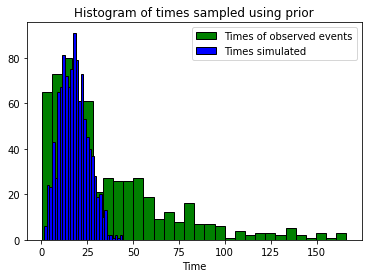

In [13]:
prior_model, prior_samples = do_sampling(
    model_path="stan/prior.stan",
    data={
        "N": normalized_features_matrix.shape[0],
            
        "mu_k": 2.5,
        "sigma_k": 0.01,
        "mu_lambda": 20,
        "sigma_lambda": 0.01
    },
    target=target_array,
    censor=censor_array,
    do_plot=True,
    fixed_param=True,
    iter_sampling=1000,
    iter_warmup=1,
    chains=1
)

Having the parameters specified empirically to match measurements to the predicted samples, we can now see on the priors for these parameters. We can plot its values to see if its distribution fits our desired one. To do that we can retrieve it from the model itself.

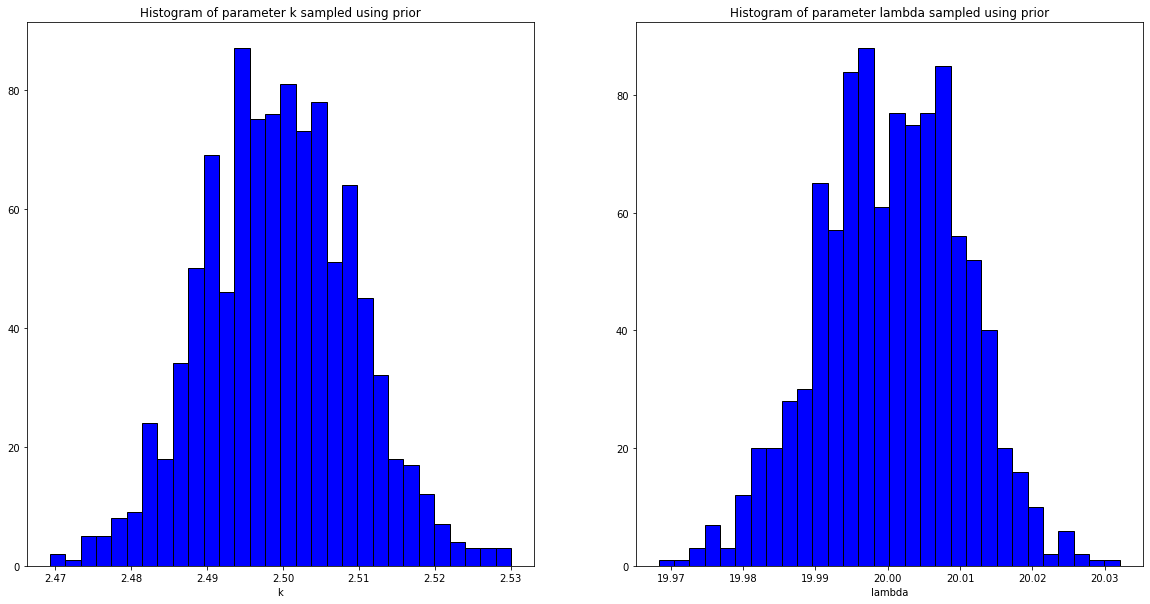

In [14]:
param_k = prior_samples.stan_variable("k")
param_lambda = prior_samples.stan_variable("lambda")

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.hist(param_k, bins=30, color="blue", edgecolor='black')
ax1.set_title('Histogram of parameter k sampled using prior')
ax1.set_xlabel('k')
ax2.hist(param_lambda, bins=30, color="blue", edgecolor='black')
ax2.set_title('Histogram of parameter lambda sampled using prior')
ax2.set_xlabel('lambda')
plt.show()

## 5. Posterior analysis of the first model

**5.1. Posterior prediction**

As it was said in the previous chapters of the document, our first model will use only Weibull distribution to predict the time employee will stay in the company before leaving. In such models, it is very important to choose the parameter values properly to make our sampled distribution reliable. It is the only thing, that our results depend on. In our experiment, we will use values of the parameters $ k $ and $ \lambda $ specified in priors in previous chapter.

```stan
data {
    int <lower=0> N; // number of observations
    vector[N] y;     // survival times
    array[N] int <lower=0,upper=1> censor;  //censoring indicator

    real <lower=0> mu_k;          // mean for k
    real <lower=0> sigma_k;       // std for k
    real <lower=0> mu_lambda;     // mean for lambda
    real <lower=0> sigma_lambda;  // std for lambda
}

parameters {
    real <lower=0> k;       // shape parameter
    real <lower=0> lambda;  // scale parameter
}

model {
    k ~ lognormal(mu_k, sigma_k);
    lambda ~ lognormal(mu_lambda, sigma_lambda);
    for (n in 1:N) {
        if (censor[n] == 0) {
            target += weibull_lpdf(y[n] | k, lambda);
        } else {
            target += weibull_lccdf(y[n] | k, lambda);
        }
    }
}

generated quantities {
    array [N] real y_sim;   // survival times
    vector[N] log_lik;      // likelihood
    for (n in 1:N) {
        if (censor[n] == 0) {
            log_lik[n] = weibull_lpdf(y[n] | k, lambda);
        } else {
            log_lik[n] = weibull_lccdf(y[n] | k, lambda);
        }
        y_sim[n] = weibull_rng(k, lambda);
    }
}
```

**5.2. Results analysis**

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:03 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


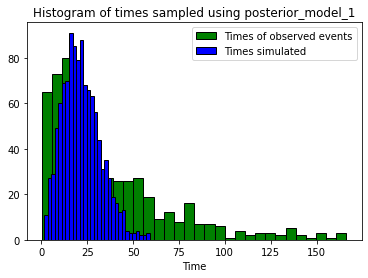

In [15]:
posterior_model_1, posterior_samples_1 = do_sampling(
    model_path="stan/posterior_model_1.stan",
    data={
        "N": normalized_features_matrix.shape[0],
        "M": normalized_features_matrix.shape[1],
        "y": target_array,
        "censor": censor_array,
        
        "mu_k": 2.5,
        "sigma_k": 0.01,
        "mu_lambda": 2,
        "sigma_lambda": 0.01
    },
    target=target_array,
    censor=censor_array,
    do_plot=True,
    chains=1
)

In [16]:
len(posterior_samples_1.draws_pd()['k'])

1000

Based on the results we can see that our predictions are not exactly consistent with our data. The difference is not too big, but it could be better. The shape of the propability density function has much greater slope than the data. Despite $ k $ parameter was sampled in the way as in the priors prediction, here we can see that the shape parameter should be set with even higher value. Also scale of the histogram is not exactly consistent with the data. We can see on both, the $ X $ axis and the $ Y $ axis that values range is too large for that data.

The main reason for that could be not sufficient amount of data to fit our distribution for the predicted employee turnover. In our dataset we have only $ 1129 $ records which is too small number.

The second reason for the inconsistency of the predictions and data could be that our predictions contain also records that were not used in the prior predictions. It means that the censored records that were used to fit posterior model, but with `weibull_lccdf` function (complementary cumulative distribution function) were excluded in the priors which may affect parameter values selection process. 

**5.3. Parameters distribution analysis**

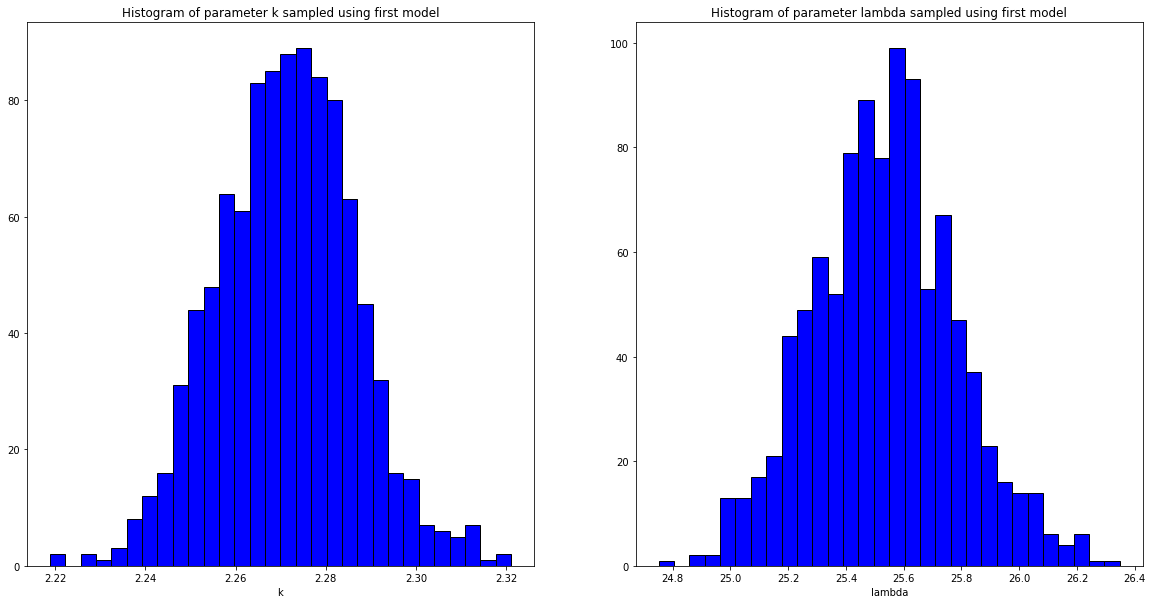

In [17]:
df_post_1 = posterior_samples_1.draws_pd()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.hist(df_post_1['k'], bins=30, color="blue", edgecolor='black')
ax1.set_title('Histogram of parameter k sampled using first model')
ax1.set_xlabel('k')
ax2.hist(df_post_1['lambda'], bins=30, color="blue", edgecolor='black')
ax2.set_title('Histogram of parameter lambda sampled using first model')
ax2.set_xlabel('lambda')
plt.show()

As we can see the histograms of each parameter, its values have changed a bit. Shape parameter $ k $ is moved to the left comparing with its distribution taken from priors, its mean is around $ k = 2.27 $. Also a mean value of the $ \lambda $ parameter is changed, now it is about $ \lambda = 25.5 $.

## 6. Posterior analysis of the second model

**6.1. Posterior prediction**

Second model that we are using in our experiment, will use Weibull distribution and also features from dataset to predict the time employee will stay in the company before leaving. That should better fit to our data as it is influenced at some level by that data. We introduced a $ \theta $ parameter mentioned in the $ 3^{rd} $ chapter that will represent regression coefficient. Including data vector it will define the scale parameter.

```stan
data {
    int <lower=0> N; // number of observations
    int <lower=0> M; // number of features
    matrix [N, M] X; // covariates matrix
    vector[N] y;     // survival times
    array[N] int <lower=0,upper=1> censor;  //censoring indicator

    real <lower=0> mu_k;          // mean for k
    real <lower=0> sigma_k;       // std for k
    real <lower=0> mu_theta;      // mean for theta
    real <lower=0> sigma_theta;   // std for theta
}

parameters {
    real<lower=0> k;              // shape parameter
    vector <lower=0> [M] theta;   // regression coefficient
}

model {
    k ~ lognormal(mu_k, sigma_k);
    theta ~ lognormal(mu_theta, sigma_theta);
    for (n in 1:N) {
        if (censor[n] == 0) {
            target += weibull_lpdf(y[n] | k, exp(X[n] * theta));
        } else {
            target += weibull_lccdf(y[n] | k, exp(X[n] * theta));
        }
    }
}

generated quantities {
    array [N] real y_sim;   // survival times
    vector[N] log_lik;      // likelihood
    for (n in 1:N) {
        if (censor[n] == 0) {
            log_lik[n] = weibull_lpdf(y[n] | k, exp(X[n] * theta));
        } else {
            log_lik[n] = weibull_lccdf(y[n] | k, exp(X[n] * theta));
        }
        y_sim[n] = weibull_rng(k, exp(X[n] * theta));
    }
}
```

**6.2. Results analysis**

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:06 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


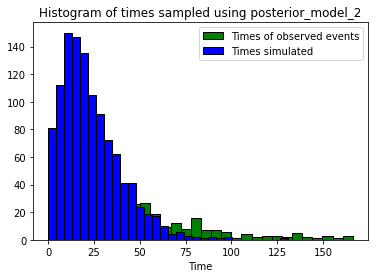

In [18]:
posterior_model_2, posterior_samples_2 = do_sampling(
    model_path="stan/posterior_model_2.stan",
    data={
        "N": normalized_features_matrix.shape[0],
        "M": normalized_features_matrix.shape[1],
        "X": normalized_features_matrix,
        "y": target_array,
        "censor": censor_array,
        
        "mu_k": 0.8,
        "sigma_k": 0.01,
        "mu_theta": 0.1,
        "sigma_theta": 0.01
    },
    target=target_array,
    censor=censor_array,
    do_plot=True,
    chains=1
)

Based on the results we can see that our predictions are much more consistent with our data comparing with the first model. The shape of the propability density function has very similar slope to our data. Scale of the histogram is also consistent with the data, but the $ \theta $ parameter is set empirically.

After a bit of adjusting parameter $ k $ and $ \theta $ we are were able to get predictionsthat are consistent with our turnover times. This adjusting was neccessary to handle small amount of data and get better results. 


**6.3. Parameters distribution analysis**

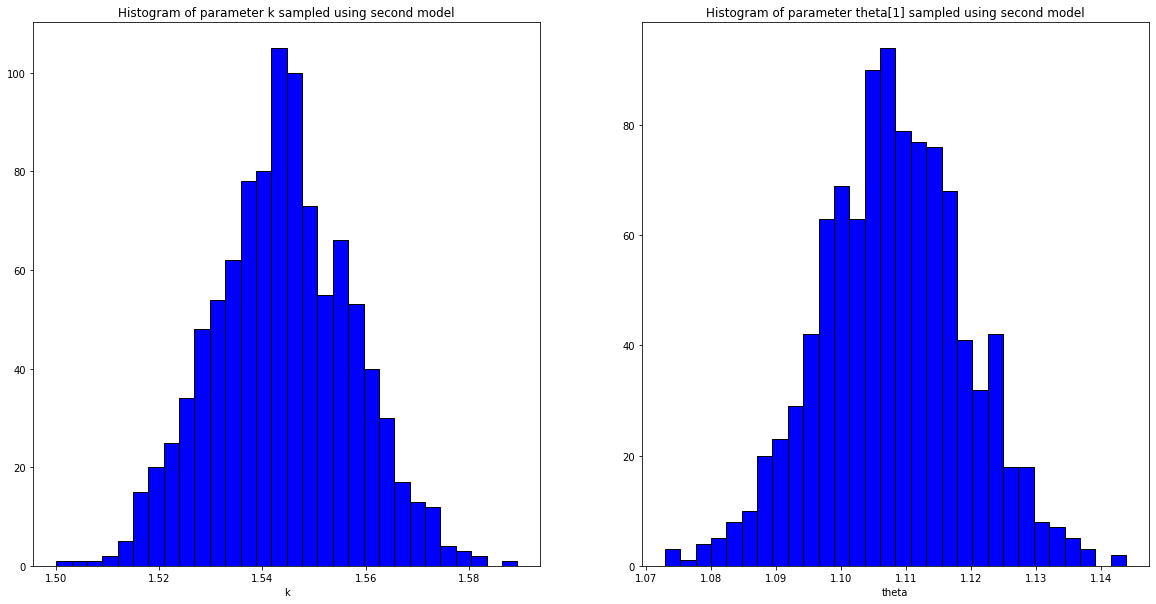

In [19]:
df_post_2 = posterior_samples_2.draws_pd()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.hist(df_post_2['k'], bins=30, color="blue", edgecolor='black')
ax1.set_title('Histogram of parameter k sampled using second model')
ax1.set_xlabel('k')
ax2.hist(df_post_2['theta[1]'], bins=30, color="blue", edgecolor='black')
ax2.set_title('Histogram of parameter theta[1] sampled using second model')
ax2.set_xlabel('theta')
plt.show()

As we can see the histograms of each parameter, its values also have changed. Shape parameter $ k $ distribution now is quite different comparing with its distribution taken from priors, its mean is around $ k = 1.54 $. Also a mean value of the $ \theta $ parameter is changed, but we have to keep in mind that this is $ \theta $ value only for the first feature in the covariates. $ \theta[1] $ represents only the first regression coefficient so value of the $ \theta $ parameter may vary over the whole vector.

## 7. Model comparison

In [20]:
az_data1 = az.from_cmdstanpy(posterior=posterior_samples_1)
az_data2 = az.from_cmdstanpy(posterior=posterior_samples_2)

**Widely Applicable Information Criterion**

In [29]:
model_dict = {"Parametric Model:":az_data1, "Semi-Parametric Model":az_data2}
model_comp = az.compare(model_dict, ic='waic', scale="deviance")
model_comp

/usr/local/lib/python3.12/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Semi-Parametric Model,0,8555.725934,5.712115,0.000000,1.000000e+00,224.170600,0.000000,False,deviance
Parametric Model:,1,15068.565539,27.751116,6512.839605,1.665335e-15,711.164902,530.006582,True,deviance


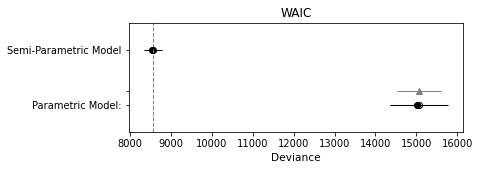

In [30]:
az.plot_compare(model_comp)
plt.title("WAIC")
plt.show()

The comparison of Semi-Parametric and Parametric models using the WAIC (Watanabe-Akaike Information Criterion) revealed that the Semi-Parametric model has better predictive accuracy. The Semi-Parametric model had a lower WAIC value of 8555.73 compared to the Parametric model's WAIC value of 15068.57. Furthermore, the Akaike weight, which approximates the probability of a model being the best in the set, was significantly higher for the Semi-Parametric model (1.0) than for the Parametric model (close to zero). The Parametric model is less complex and has a lower effective number of parameters (p_waic 5.71) compared to the Semi-Parametric model (27.75). The standard errors of the WAIC estimates for both models were 224.17 and 711.16, respectively. It should be noted, however, that the Parametric model generated warnings during WAIC calculations, indicating high posterior variance of the log predictive densities for some samples. This warning suggests potential issues with the reliability of WAIC results for the Parametric model, further supporting the superiority of the Semi-Parametric model.

**Leave-one-out Cross Validation**

In [31]:
model_comp = az.compare(model_dict, ic='loo', scale="deviance")
model_comp

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Semi-Parametric Model,0,8555.726458,5.712377,0.000000,1.0,224.170675,0.000000,False,deviance
Parametric Model:,1,15068.947218,27.941955,6513.220761,0.0,711.226206,530.071518,False,deviance


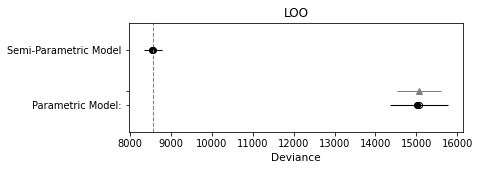

In [32]:
az.plot_compare(model_comp)
plt.title("LOO")
plt.show()

Comparison of the Semi-Parametric and Parametric models using Leave-One-Out Cross-Validation (LOO) showed that the Semi-Parametric model has higher predictive accuracy. The Semi-Parametric model achieved a lower LOO value of 8555.73, compared to the Parametric model's value of 15068.95. Additionally, the Akaike weight for the Semi-Parametric model was 1.0, much higher than for the Parametric model (0.0). This suggests that the Semi-Parametric model is the better model. In terms of complexity, the Parametric model was simpler, with an effective number of parameters equal to 5.71, compared to 27.94 in the Semi-Parametric model. The standard errors for the LOO estimates for the models were 224.17 for the Semi-Parametric model and 711.23 for the Parametric model, highlighting the differences in the precision of the estimates between them.

**Model Comparison Conclusion**

The Semi-Parametric model demonstrates better predictive accuracy than the Parametric model, as confirmed by both WAIC and LOO metrics. The Semi-Parametric model achieved lower WAIC and LOO values and a higher Akaike weight, indicating its superior performance. Although the Parametric model is simpler, the Semi-Parametric model, despite its greater complexity, offers better performance. Differences in standard errors also highlight the superiority of the Semi-Parametric model. As a result, the Semi-Parametric model is the preferred choice in this analysis.